In [50]:
import os
import builtins
import json
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import radar_factory

from pathlib import Path
from scipy.stats import kruskal, mannwhitneyu, wilcoxon

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 14
plt.rcParams['text.usetex'] = True

### Load problems

In [51]:
# we need to know some things about the data
data_path = './data/problems/'

all_files  = list(os.listdir(data_path)) if os.path.isdir(data_path) else [ os.path.basename(data_path) ]
data_files = sorted([ f for f in all_files if f.endswith('.json') ])

problem_info = {}

# aggregate problem information that we can use to evaluate expressions
for f in data_files:
    with builtins.open(os.path.join(data_path, f), 'r') as h:
        info           = json.load(h)
        metadata       = info['metadata']
        target         = metadata['target']
        training_rows  = metadata['training_rows']
        training_start = training_rows['start']
        training_end   = training_rows['end']
        test_rows      = metadata['test_rows']
        test_start     = test_rows['start']
        test_end       = test_rows['end']
        problem_name   = metadata['name']
        problem_csv    = metadata['filename']

    problem_data = pd.read_csv(os.path.join(data_path, f'{problem_csv}.gz'))
    problem_info[problem_name] = {
        'name' : problem_name,
        'training_range' : (training_start, training_end),
        'test_range' : (test_start, test_end),
        'target' : target,
        'data' : problem_data
    }

def range_size(problem):
    a, b = problem_info[problem]['training_range']
    return b-a

### Load results

In [52]:
df = pd.read_csv('./results/results_full.csv.gz')

### Structure of the results

The files in `./data/without_nls` and `./data/with_nls` contain runs with extended statistics, aggregated every generation. This is why these files are quite large (1.6Gb uncompressed). The `aggregated_last_gen.csv` file contains only last generation stats from both `without_nls` and `with_nls` runs from `./data`. Additionally, this file has four extra columns, `r2_train_v`, `r2_test_v`, `r2_train_b` and `r2_test_b` which represent the R2 values of the final expressions re-evaluated with the `Stl` backend (`_v` suffix) and with the original backend `_b` suffix, but with linear scaling.

In [53]:
df1 = df[df.jac_eval == 0]
df2 = df[df.jac_eval > 0]

In [54]:
df1.shape, df2.shape

((9009000, 24), (1311892, 24))

### Filter the dataframe and keep only run stats from the last generation (which also contain the final expression and energy value)

In [55]:
runs_without_nls = df1.dropna(subset=['expression'], axis=0).reset_index(drop=True)
runs_with_nls = df2.dropna(subset=['expression'], axis=0).reset_index(drop=True)

In [56]:
runs_without_nls.r2_train_v = runs_without_nls.r2_train_v.fillna(0.0).clip(0, 1)
runs_without_nls.r2_train_b = runs_without_nls.r2_train_b.fillna(0.0).clip(0, 1)

runs_without_nls.r2_test_v = runs_without_nls.r2_test_v.fillna(0.0).clip(0, 1)
runs_without_nls.r2_test_b = runs_without_nls.r2_test_b.fillna(0.0).clip(0, 1)

runs_with_nls.r2_train_v = runs_with_nls.r2_train_v.fillna(0.0).clip(0, 1)
runs_with_nls.r2_train_b = runs_with_nls.r2_train_b.fillna(0.0).clip(0, 1)

runs_with_nls.r2_test_v = runs_with_nls.r2_test_v.fillna(0.0).clip(0, 1)
runs_with_nls.r2_test_b = runs_with_nls.r2_test_b.fillna(0.0).clip(0, 1)


In [57]:
for k, v in runs_with_nls.groupby(['problem', 'backend']):
    print(k, v['r2_test_v'].median())

('Airfoil Self-Noise', 'Eigen') 0.5811912219303106
('Airfoil Self-Noise', 'Mad_Transcendental_Fast') 0.5658330196071115
('Airfoil Self-Noise', 'Mad_Transcendental_Faster') 0.5821834533765583
('Airfoil Self-Noise', 'Mad_Transcendental_Fastest') 0.5459158453538014
('Airfoil Self-Noise', 'Stl') 0.5718915301909114
('Airfoil Self-Noise', 'Vdt') 0.5706119177851965
('Chemical-I', 'Eigen') 0.811896665675653
('Chemical-I', 'Mad_Transcendental_Fast') 0.8147243841338243
('Chemical-I', 'Mad_Transcendental_Faster') 0.8151623594925014
('Chemical-I', 'Mad_Transcendental_Fastest') 0.8006965642089419
('Chemical-I', 'Stl') 0.8181609286291015
('Chemical-I', 'Vdt') 0.81305413775354
('Concrete Compressive Strength', 'Eigen') 0.44627667397070503
('Concrete Compressive Strength', 'Mad_Transcendental_Fast') 0.4624247040140266
('Concrete Compressive Strength', 'Mad_Transcendental_Faster') 0.4523793550601611
('Concrete Compressive Strength', 'Mad_Transcendental_Fastest') 0.4673385461012412
('Concrete Compressiv

### Compute time delta

In [58]:
df1['elapsed_delta'] = df1.groupby(['problem', 'backend'])['elapsed'].transform(pd.DataFrame.diff).apply(lambda x: 0 if x < 0 else x)
df2['elapsed_delta'] = df2.groupby(['problem', 'backend'])['elapsed'].transform(pd.DataFrame.diff).apply(lambda x: 0 if x < 0 else x)

In [59]:
df1.elapsed_delta.min(), df1.elapsed_delta.max()

(0.0, 0.018127999999999922)

In [60]:
df1.groupby(['problem', 'backend']).median(numeric_only=True)

generation  r2_train  r2_test  \
problem            backend                                                     
Airfoil Self-Noise Eigen                            500.0     0.820    0.590   
                   Mad_Transcendental_Fast          500.0     0.821    0.599   
                   Mad_Transcendental_Faster        500.0     0.820    0.603   
                   Mad_Transcendental_Fastest       500.0     0.816    0.569   
                   Stl                              500.0     0.824    0.601   
...                                                   ...       ...      ...   
Vladislavleva-8    Mad_Transcendental_Fast          500.0     0.985    0.820   
                   Mad_Transcendental_Faster        500.0     0.979    0.839   
                   Mad_Transcendental_Fastest       500.0     0.990    0.821   
                   Stl                              500.0     0.987    0.846   
                   Vdt                              500.0     0.983    0.817   

                                               mae_train  mae_test  \
problem            backend                                           
Airfoil Self-Noise Eigen                          2.1500     3.360   
                   Mad_Transcendental_Fast        2.1500     3.310   
                   Mad_Transcendental_Faster      2.1500     3.320   
                   Mad_Transcendental_Fastest     2.1400     3.430   
                   Stl                            2.1000     3.350   
...                                                  ...       ...   
Vladislavleva-8    Mad_Transcendental_Fast        0.0886     0.447   
                   Mad_Transcendental_Faster      0.1040     0.442   
                   Mad_Transcendental_Fastest     0.0783     0.432   
                   Stl                            0.0854     0.414   
                   Vdt                            0.0946     0.426   

                                               nmse_train  nmse_test  avg_fit  \
problem            backend                                                      
Airfoil Self-Noise Eigen                           0.1800      0.410   -0.682   
                   Mad_Transcendental_Fast         0.1790      0.401   -0.683   
                   Mad_Transcendental_Faster       0.1800      0.397   -0.677   
                   Mad_Transcendental_Fastest      0.1840      0.431   -0.686   
                   Stl                             0.1760      0.399   -0.684   
...                                                   ...        ...      ...   
Vladislavleva-8    Mad_Transcendental_Fast         0.0148      0.180   -0.850   
                   Mad_Transcendental_Faster       0.0208      0.161   -0.843   
                   Mad_Transcendental_Fastest      0.0103      0.179   -0.853   
                   Stl                             0.0133      0.154   -0.847   
                   Vdt                             0.0173      0.183   -0.847   

                                               avg_len       eval  ...  \
problem            backend                                         ...   
Airfoil Self-Noise Eigen                          29.3  1002000.0  ...   
                   Mad_Transcendental_Fast        29.5  1002000.0  ...   
                   Mad_Transcendental_Faster      27.7  1002000.0  ...   
                   Mad_Transcendental_Fastest     29.0  1002000.0  ...   
                   Stl                            29.3  1002000.0  ...   
...                                                ...        ...  ...   
Vladislavleva-8    Mad_Transcendental_Fast        20.7  1002000.0  ...   
                   Mad_Transcendental_Faster      20.0  1002000.0  ...   
                   Mad_Transcendental_Fastest     22.5  1002000.0  ...   
                   Stl                            20.9  1002000.0  ...   
                   Vdt                            21.2  1002000.0  ...   

                                               jac_eval  opt_time  \
problem  

### Learn a model for energy

Train a Random Forest using time delta and average tree length as input variables

In [61]:
def fill_energy_values(myruns, mydata):
    r = myruns.select_dtypes(include=np.number).replace([np.inf, -np.inf], np.nan).dropna(axis=0).clip()
    r['elapsed_delta'] = r['elapsed'] # will be useful below
    X = r[['elapsed_delta', 'avg_len']]
    y = r['energy']
    rf = RandomForestRegressor()
    rf.fit(X, y)
    mydata['energy'] = rf.predict(mydata[['elapsed_delta', 'avg_len']])


# Use the model to fill in energy values for the entire data
fill_energy_values(runs_without_nls, df1)
fill_energy_values(runs_with_nls, df2)


In [62]:
df1

,problem,symbols,generation,r2_train,r2_test,mae_train,mae_test,nmse_train,nmse_test,avg_fit,...,seed,elapsed,energy,expression,backend,r2_train_v,r2_test_v,r2_train_b,r2_test_b,elapsed_delta
0,Airfoil Self-Noise,div_exp_log_sin_cos_sqrt_tanh,0.0,0.387,0.085,4.0700,5.55,0.61300,0.915,2.580000e+38,...,3.157811e+09,0.001781,162.3112,NaN,Mad_Transcendental_Faster,NaN,NaN,NaN,NaN,NaN
1,Airfoil Self-Noise,div_exp_log_sin_cos_sqrt_tanh,1.0,0.436,0.251,4.0800,5.10,0.56400,0.749,5.950000e+37,...,3.157811e+09,0.003214,136.9925,NaN,Mad_Transcendental_Faster,NaN,NaN,NaN,NaN,0.001433
2,Airfoil Self-Noise,div_exp_log_sin_cos_sqrt_tanh,2.0,0.514,0.337,3.7000,4.72,0.48600,0.663,-9.220000e-02,...,3.157811e+09,0.004559,137.1058,NaN,Mad_Transcendental_Faster,NaN,NaN,NaN,NaN,0.001345
3,Airfoil Self-Noise,div_exp_log_sin_cos_sqrt_tanh,3.0,0.580,0.159,3.4400,4.78,0.42000,0.841,-1.670000e-01,...,3.157811e+09,0.005901,137.3784,NaN,Mad_Transcendental_Faster,NaN,NaN,NaN,NaN,0.001342
4,Airfoil Self-Noise,div_exp_log_sin_cos_sqrt_tanh,4.0,0.595,0.354,3.4200,4.65,0.40500,0.646,-2.490000e-01,...,3.157811e+09,0.007218,137.4910,NaN,Mad_Transcendental_Faster,NaN,NaN,NaN,NaN,0.001317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9008995,Vladislavleva-8,div_exp_log_sin_cos_sqrt_tanh,996.0,0.993,NaN,0.0588,NaN,0.00734,NaN,-8.930000e-01,...,3.011846e+08,1.245777,136.9925,NaN,Stl,NaN,NaN,NaN,NaN,0.001242
9008996,Vladislavleva-8,div_exp_log_sin_cos_sqrt_tanh,997.0,0.993,NaN,0.0588,NaN,0.00734,NaN,-8.920000e-01,...,3.011846e+08,1.247025,136.9925,NaN,Stl,NaN,NaN,NaN,NaN,0.001248
9008997,Vladislavleva-8,div_exp_log_sin_cos_sqrt_tanh,998.0,0.993,NaN,0.0588,NaN,0.00734,NaN,-8.920000e-01,...,3.011846e+08,1.248290,136.9925,NaN,Stl,NaN,NaN,NaN,NaN,0.001265
9008998,Vladislavleva-8,div_exp_log_sin_cos_sqrt_tanh,999.0,0.993,NaN,0.0588,NaN,0.00734,NaN,-8.940000e-01,...,3.011846e+08,1.249535,136.9925,NaN,Stl,NaN,NaN,NaN,NaN,0.001245


In [63]:
df2

,problem,symbols,generation,r2_train,r2_test,mae_train,mae_test,nmse_train,nmse_test,avg_fit,...,seed,elapsed,energy,expression,backend,r2_train_v,r2_test_v,r2_train_b,r2_test_b,elapsed_delta
9009000,Airfoil Self-Noise,div_exp_log_sin_cos_sqrt_tanh,0.0,0.387,0.126,4.1600,5.350,0.613000,0.874,inf,...,1.943992e+09,0.006813,59.3655,NaN,Mad_Transcendental_Faster,NaN,NaN,NaN,NaN,NaN
9009001,Airfoil Self-Noise,div_exp_log_sin_cos_sqrt_tanh,1.0,0.509,0.138,3.7900,5.420,0.491000,0.862,6.300000e+37,...,1.943992e+09,0.012225,34.7476,NaN,Mad_Transcendental_Faster,NaN,NaN,NaN,NaN,0.005412
9009002,Airfoil Self-Noise,div_exp_log_sin_cos_sqrt_tanh,2.0,0.517,0.097,3.7100,5.480,0.483000,0.903,-9.400000e-02,...,1.943992e+09,0.017253,34.3815,NaN,Mad_Transcendental_Faster,NaN,NaN,NaN,NaN,0.005028
9009003,Airfoil Self-Noise,div_exp_log_sin_cos_sqrt_tanh,3.0,0.532,0.110,3.6000,5.630,0.468000,0.890,-1.680000e-01,...,1.943992e+09,0.022322,34.2936,NaN,Mad_Transcendental_Faster,NaN,NaN,NaN,NaN,0.005069
9009004,Airfoil Self-Noise,div_exp_log_sin_cos_sqrt_tanh,4.0,0.655,0.362,3.0600,4.460,0.345000,0.638,-2.470000e-01,...,1.943992e+09,0.026957,34.1871,NaN,Mad_Transcendental_Faster,NaN,NaN,NaN,NaN,0.004635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10320887,Vladislavleva-8,div_exp_log_sin_cos_sqrt_tanh,138.0,1.000,0.838,0.0145,0.402,0.000336,0.162,-9.160000e-01,...,1.630222e+09,0.412368,34.7507,NaN,Stl,NaN,NaN,NaN,NaN,0.003280
10320888,Vladislavleva-8,div_exp_log_sin_cos_sqrt_tanh,139.0,1.000,0.838,0.0145,0.402,0.000336,0.162,-9.150000e-01,...,1.630222e+09,0.415653,34.7507,NaN,Stl,NaN,NaN,NaN,NaN,0.003285
10320889,Vladislavleva-8,div_exp_log_sin_cos_sqrt_tanh,140.0,1.000,0.838,0.0145,0.402,0.000336,0.162,-9.140000e-01,...,1.630222e+09,0.418974,34.7507,NaN,Stl,NaN,NaN,NaN,NaN,0.003321
10320890,Vladislavleva-8,div_exp_log_sin_cos_sqrt_tanh,141.0,1.000,0.838,0.0145,0.402,0.000336,0.162,-9.150000e-01,...,1.630222e+09,0.422244,34.7507,NaN,Stl,NaN,NaN,NaN,NaN,0.003270


### Compute NEPS and NPW

In [64]:
def aggregate_energy_data(mydf):
    mydf_mean = mydf.groupby(['problem', 'backend', 'generation']).mean(numeric_only=True).reset_index()

    frames = []
    for k, v in mydf_mean.groupby(['problem', 'backend']):
        p, b = k
        s = range_size(p)
        t = v.elapsed_delta
        r = v.res_eval.diff()
        l = v.avg_len
        e = v.energy
        n = s * r * l / t
        m = s * r * l / e
        d = pd.DataFrame.from_dict({
            'backend': [b] * len(l),
            'problem': [p] * len(l),
            'gen': v.generation,
            'length': v.avg_len,
            'energy': v.energy,
            'elapsed': v.elapsed,
            'elapsed_delta': v.elapsed_delta,
            'neps': n,
            'npw': m
        })
        frames.append(d)

    data = pd.concat(frames)
    data = data[data.gen < 1000]

    return data

In [65]:
energy_data_without_nls = aggregate_energy_data(df1)
energy_data_without_nls

,backend,problem,gen,length,energy,elapsed,elapsed_delta,neps,npw
0,Eigen,Airfoil Self-Noise,0.0,41.832,137.240391,0.001507,0.000000,NaN,NaN
1,Eigen,Airfoil Self-Noise,1.0,23.734,137.243870,0.002776,0.001268,1.871604e+10,172933.042474
2,Eigen,Airfoil Self-Noise,2.0,19.117,136.802083,0.004111,0.001336,1.431031e+10,139742.024250
3,Eigen,Airfoil Self-Noise,3.0,20.145,136.981461,0.005407,0.001295,1.555262e+10,147063.696452
4,Eigen,Airfoil Self-Noise,4.0,20.689,136.882002,0.006681,0.001274,1.623724e+10,151144.779428
...,...,...,...,...,...,...,...,...,...
90084,Vdt,Vladislavleva-8,995.0,21.319,135.902894,1.042754,0.001047,1.018080e+09,7843.467999
90085,Vdt,Vladislavleva-8,996.0,21.318,135.915796,1.043799,0.001044,1.020518e+09,7842.355571
90086,Vdt,Vladislavleva-8,997.0,21.319,135.905444,1.044841,0.001043,1.022259e+09,7843.320831
90087,Vdt,Vladislavleva-8,998.0,21.305,135.912999,1.045890,0.001049,1.015762e+09,7837.734491


In [66]:
energy_data_with_nls = aggregate_energy_data(df2)
energy_data_with_nls

,backend,problem,gen,length,energy,elapsed,elapsed_delta,neps,npw
0,Eigen,Airfoil Self-Noise,0.0,41.697000,34.997455,0.005082,0.000000,NaN,NaN
1,Eigen,Airfoil Self-Noise,1.0,23.570000,34.754082,0.009482,0.004401,1.968697e+10,2.492803e+06
2,Eigen,Airfoil Self-Noise,2.0,19.313000,34.341842,0.014429,0.004947,1.686675e+10,2.429472e+06
3,Eigen,Airfoil Self-Noise,3.0,20.192000,34.421337,0.019515,0.005087,1.721966e+10,2.544604e+06
4,Eigen,Airfoil Self-Noise,4.0,20.961000,34.463924,0.024679,0.005163,1.757097e+10,2.632398e+06
...,...,...,...,...,...,...,...,...,...
14054,Vdt,Vladislavleva-8,146.0,36.372727,34.667618,0.312562,0.001796,1.754791e+08,9.088617e+03
14055,Vdt,Vladislavleva-8,147.0,31.960000,34.585380,0.296584,0.001834,-8.161850e+08,-4.329025e+04
14056,Vdt,Vladislavleva-8,148.0,26.433333,34.475167,0.277359,0.001552,-9.865379e+08,-4.441187e+04
14057,Vdt,Vladislavleva-8,149.0,18.300000,34.337400,0.254781,0.001679,2.498221e+09,1.221558e+05


### Energy

Note that due to how we are calling `perf`, we only get the energy value at the end of the run. In order to approximate energy usage per generation, I have trained a random forest regressor using the last generation values.

The input features for the regressor are elapsed time and average tree length. Based on those, we are able to obtain a prediction accuracy of 99.1%. We then apply this prediction step on the entire data, with the very important observation that the time input feature must be transformed into a delta (because we need elapsed time for one generation, not for the total). This is leading to a reasonable estimation.



### NEPS

Next, we compute NEPS (node evaluations per second) using the formula:

$$
    \begin{aligned}
        \text{NEPS} &= \frac{\text{problem size} \times \text{average length} \times \Delta R}{\Delta T}
    \end{aligned}
$$ wher $\Delta{R}$ is the delta of residual evaluations from one generation to the next and $\Delta T$ is the time delta.

### NPW

Since energy is approximated by the Random Forest model:

$$
    \hat{E} = f(\Delta T, \text{avg. len.})
$$ the formula for NPW becomes:

$$
    \begin{aligned}
        \text{NPW} &= \frac{\text{problem size} \times \text{average length} \times \Delta R}{\hat{E}}
    \end{aligned}
$$

Energy efficiency and, by extension, the performance per watt metric, depends on the distribution of function primitives in the population. We can imagine that if expensive function symbols proliferate in the population because they improve fitness, then efficiency will decrease as they proliferate.

### Aggregate final NEPS / NPW

In [67]:
def get_energy_stats(runs, data):
    g1 = dict(list(runs.groupby(['problem', 'backend'])))
    g2 = dict(list(data.groupby(['problem', 'backend'])))

    tmp = {
        'problem': [],
        'rows': [],
        'backend': [],
        'elapsed': [],
        'neps_last': [],
        'neps_avg': [],
        'npw_last': [],
        'npw_avg': [],
        'energy': [],
        'avg_len': [],
    }
    for k in g1.keys():
        v = g1[k]
        u = g2[k]
        L = v['avg_len'].mean()
        E = v['energy'].mean()
        T = v['elapsed'].mean()
        R = v['res_eval'].mean()
        J = v['jac_eval'].mean()
        S = range_size(k[0])

        neps_lst = S * (R+2*J) * L / T
        neps_avg = u['neps'].mean()

        npw_lst = S * R * L / E
        npw_avg = u['npw'].mean()

        tmp['problem'].append(k[0])
        tmp['rows'].append(range_size(k[0]))
        tmp['backend'].append(k[1])
        tmp['elapsed'].append(T)
        tmp['neps_last'].append(neps_lst)
        tmp['neps_avg'].append(neps_avg)
        tmp['npw_last'].append(npw_lst)
        tmp['npw_avg'].append(npw_avg)
        tmp['avg_len'].append(L)
        tmp['energy'].append(E)

    return pd.DataFrame.from_dict(tmp)

In [68]:
npw_without_nls = get_energy_stats(runs_without_nls, energy_data_without_nls)
npw_without_nls

,problem,rows,backend,elapsed,neps_last,neps_avg,npw_last,npw_avg,energy,avg_len
0,Airfoil Self-Noise,1000,Eigen,1.243226,2.486054e+10,2.385470e+10,1.961239e+08,216564.488335,157.5905,30.9070
1,Airfoil Self-Noise,1000,Mad_Transcendental_Fast,1.343455,2.287037e+10,2.202235e+10,1.601049e+08,215978.916019,191.9073,30.7250
2,Airfoil Self-Noise,1000,Mad_Transcendental_Faster,1.280443,2.169581e+10,2.143197e+10,1.572377e+08,200746.388939,176.6768,27.7800
3,Airfoil Self-Noise,1000,Mad_Transcendental_Fastest,1.224375,2.418153e+10,2.402851e+10,1.842561e+08,214789.624762,160.6853,29.6070
4,Airfoil Self-Noise,1000,Stl,1.928516,1.571121e+10,1.541069e+10,1.092190e+08,216795.740119,277.4180,30.2990
...,...,...,...,...,...,...,...,...,...,...
85,Vladislavleva-8,50,Mad_Transcendental_Fast,1.068165,1.020120e+09,1.031699e+09,7.145583e+06,8096.507057,152.4937,21.7930
86,Vladislavleva-8,50,Mad_Transcendental_Faster,1.051310,9.624617e+08,9.980250e+08,6.728663e+06,7740.518210,150.3784,20.2368
87,Vladislavleva-8,50,Mad_Transcendental_Fastest,1.042386,1.076766e+09,1.086452e+09,7.607971e+06,8317.622801,147.5303,22.4480
88,Vladislavleva-8,50,Stl,1.238844,8.749753e+08,8.751203e+08,6.187782e+06,7969.603763,175.1772,21.6790


In [69]:
npw_with_nls = get_energy_stats(runs_with_nls, energy_data_with_nls)
npw_with_nls

,problem,rows,backend,elapsed,neps_last,neps_avg,npw_last,npw_avg,energy,avg_len
0,Airfoil Self-Noise,1000,Eigen,3.205914,1.953130e+10,1.009350e+10,1.459090e+08,5.129418e+06,220.2631,47.367
1,Airfoil Self-Noise,1000,Mad_Transcendental_Fast,3.409778,1.825107e+10,9.177367e+09,1.337759e+08,4.990713e+06,238.3091,47.046
2,Airfoil Self-Noise,1000,Mad_Transcendental_Faster,3.271930,1.885489e+10,9.186134e+09,1.387497e+08,5.305695e+06,229.0443,46.726
3,Airfoil Self-Noise,1000,Mad_Transcendental_Fastest,2.846537,2.014553e+10,1.003598e+10,1.569089e+08,4.686125e+06,196.3652,44.069
4,Airfoil Self-Noise,1000,Stl,3.908171,1.576231e+10,7.521510e+09,1.015467e+08,4.850240e+06,311.4145,46.603
...,...,...,...,...,...,...,...,...,...,...
85,Vladislavleva-8,50,Mad_Transcendental_Fast,0.323707,8.057105e+09,3.298970e+09,2.747304e+07,2.160852e+05,48.4498,39.384
86,Vladislavleva-8,50,Mad_Transcendental_Faster,0.317086,8.078139e+09,3.404787e+09,2.766102e+07,2.183569e+05,47.2588,38.679
87,Vladislavleva-8,50,Mad_Transcendental_Fastest,0.283603,7.738775e+09,3.382030e+09,2.749656e+07,1.935325e+05,41.0071,33.216
88,Vladislavleva-8,50,Stl,0.424264,6.114998e+09,2.571300e+09,2.009394e+07,2.206463e+05,65.9214,39.182


In [70]:
backends = npw_without_nls.backend.unique()
results = {
    'backend': backends,
    'npw_without_nls': [],
    'npw_with_nls': [],
    'nps_without_nls': [],
    'nps_with_nls': [],
    'energy_without_nls': [],
    'energy_with_nls': [],
    'r2_without_nls': [],
    'r2_with_nls': [],
    'abs_r2_without_nls': [],
    'abs_r2_with_nls': [],
    'rel_r2_without_nls': [],
    'rel_r2_with_nls': [],
    'avg_len_without_nls': [],
    'avg_len_with_nls': [],
    'elapsed_without_nls': [],
    'elapsed_with_nls': []
}

names = {
    'Mad_Transcendental_Fast': 'Mad-16',
    'Mad_Transcendental_Faster': 'Mad-10',
    'Mad_Transcendental_Fastest': 'Mad-04',
}

def get_name(x):
    return names[x] if x in names else x

r2_eigen_without_nls = runs_without_nls[runs_without_nls.backend == 'Eigen'].r2_test_v.mean()
r2_eigen_with_nls = runs_with_nls[runs_with_nls.backend == 'Eigen'].r2_test_v.mean()

for b in backends:
    d1 = npw_without_nls[(npw_without_nls.backend == b) & (npw_without_nls.rows >= 0)]
    d2 = npw_with_nls[(npw_with_nls.backend == b) & (npw_with_nls.rows >= 0)]

    r1 = runs_without_nls[runs_without_nls.backend == b]
    r2 = runs_with_nls[runs_with_nls.backend == b]

    results['npw_without_nls'].append(d1['npw_last'].mean())
    results['npw_with_nls'].append(d2['npw_last'].mean())

    results['nps_without_nls'].append(d1['neps_last'].mean())
    results['nps_with_nls'].append(d2['neps_last'].mean())

    results['energy_without_nls'].append(d1['energy'].mean())
    results['energy_with_nls'].append(d2['energy'].mean())

    results['avg_len_without_nls'].append(d1['avg_len'].mean())
    results['avg_len_with_nls'].append(d2['avg_len'].mean())

    results['elapsed_without_nls'].append(d1['elapsed'].mean())
    results['elapsed_with_nls'].append(d2['elapsed'].mean())

    r2_without_nls = r1['r2_test_v'].clip(0, 1).mean()
    r2_with_nls = r2['r2_test_v'].clip(0, 1).mean()

    results['r2_without_nls'].append(r2_without_nls)
    results['r2_with_nls'].append(r2_with_nls)

    results['abs_r2_without_nls'].append(r2_without_nls-r2_eigen_without_nls)
    results['abs_r2_with_nls'].append(r2_with_nls-r2_eigen_with_nls)

    results['rel_r2_without_nls'].append((r2_without_nls-r2_eigen_without_nls)/r2_eigen_without_nls*100)
    results['rel_r2_with_nls'].append((r2_with_nls-r2_eigen_with_nls)/r2_eigen_with_nls*100)


fpw = pd.DataFrame.from_dict(results)
fpw.backend = fpw.backend.apply(get_name)
fpw = fpw.drop(['r2_without_nls', 'r2_with_nls'], axis=1)
fpw = fpw.reindex([0, 4, 5, 1, 2, 3])
fpw

,backend,npw_without_nls,npw_with_nls,nps_without_nls,nps_with_nls,energy_without_nls,energy_with_nls,abs_r2_without_nls,abs_r2_with_nls,rel_r2_without_nls,rel_r2_with_nls,avg_len_without_nls,avg_len_with_nls,elapsed_without_nls,elapsed_with_nls
0,Eigen,1.352736e+08,1.148583e+08,1.764537e+10,2.467884e+10,178.173420,174.223960,0.000000,0.000000,0.000000,0.000000,29.472627,38.582767,1.347693,1.731197
4,Stl,6.708715e+07,7.589015e+07,8.970894e+09,1.912875e+10,334.918952,262.779688,0.007082,0.006860,0.854978,0.812489,29.678493,38.661520,2.587407,2.220640
5,Vdt,1.202277e+08,1.135544e+08,1.686044e+10,2.465763e+10,193.146567,174.295820,-0.001635,0.002370,-0.197357,0.280676,29.439147,38.400280,1.389810,1.706564
1,Mad-16,1.105405e+08,1.079869e+08,1.580977e+10,2.424115e+10,207.015500,183.464733,-0.002682,0.007457,-0.323733,0.883283,29.704207,38.895627,1.469160,1.775299
2,Mad-10,1.165834e+08,1.101239e+08,1.641864e+10,2.420056e+10,197.251587,178.784073,-0.006202,0.005155,-0.748731,0.610601,29.201133,38.589007,1.415902,1.756324
3,Mad-04,1.427427e+08,1.255464e+08,1.887683e+10,2.519026e+10,172.604493,158.165607,-0.010941,-0.011817,-1.320724,-1.399691,29.958707,37.834167,1.279651,1.669026


In [71]:
formatters = {
    'npw_without_nls': '{:.2e}',
    'npw_with_nls': '{:.2e}',
    'nps_without_nls': '{:.2e}',
    'nps_with_nls': '{:.2e}',
    'energy_without_nls': '{:.2f}',
    'energy_with_nls': '{:.2f}',
    'abs_r2_without_nls': '{:.2e}',
    'abs_r2_with_nls': '{:.2e}',
    'rel_r2_without_nls': '{:.2e}',
    'rel_r2_with_nls': '{:.2e}',
    'elapsed_without_nls': '{:.2f}',
    'elapsed_with_nls': '{:.2f}',
    'avg_len_without_nls': '{:.1f}',
    'avg_len_with_nls': '{:.1f}'
}

In [72]:
for name, formatter in formatters.items():
    fpw[name] = fpw[name].apply(formatter.format)
fpw

,backend,npw_without_nls,npw_with_nls,nps_without_nls,nps_with_nls,energy_without_nls,energy_with_nls,abs_r2_without_nls,abs_r2_with_nls,rel_r2_without_nls,rel_r2_with_nls,avg_len_without_nls,avg_len_with_nls,elapsed_without_nls,elapsed_with_nls
0,Eigen,1.35e+08,1.15e+08,1.76e+10,2.47e+10,178.17,174.22,0.00e+00,0.00e+00,0.00e+00,0.00e+00,29.5,38.6,1.35,1.73
4,Stl,6.71e+07,7.59e+07,8.97e+09,1.91e+10,334.92,262.78,7.08e-03,6.86e-03,8.55e-01,8.12e-01,29.7,38.7,2.59,2.22
5,Vdt,1.20e+08,1.14e+08,1.69e+10,2.47e+10,193.15,174.30,-1.63e-03,2.37e-03,-1.97e-01,2.81e-01,29.4,38.4,1.39,1.71
1,Mad-16,1.11e+08,1.08e+08,1.58e+10,2.42e+10,207.02,183.46,-2.68e-03,7.46e-03,-3.24e-01,8.83e-01,29.7,38.9,1.47,1.78
2,Mad-10,1.17e+08,1.10e+08,1.64e+10,2.42e+10,197.25,178.78,-6.20e-03,5.16e-03,-7.49e-01,6.11e-01,29.2,38.6,1.42,1.76
3,Mad-04,1.43e+08,1.26e+08,1.89e+10,2.52e+10,172.60,158.17,-1.09e-02,-1.18e-02,-1.32e+00,-1.40e+00,30.0,37.8,1.28,1.67


In [73]:
fpw.transpose()

,0,4,5,1,2,3
backend,Eigen,Stl,Vdt,Mad-16,Mad-10,Mad-04
npw_without_nls,1.35e+08,6.71e+07,1.20e+08,1.11e+08,1.17e+08,1.43e+08
npw_with_nls,1.15e+08,7.59e+07,1.14e+08,1.08e+08,1.10e+08,1.26e+08
nps_without_nls,1.76e+10,8.97e+09,1.69e+10,1.58e+10,1.64e+10,1.89e+10
nps_with_nls,2.47e+10,1.91e+10,2.47e+10,2.42e+10,2.42e+10,2.52e+10
energy_without_nls,178.17,334.92,193.15,207.02,197.25,172.60
energy_with_nls,174.22,262.78,174.30,183.46,178.78,158.17
abs_r2_without_nls,0.00e+00,7.08e-03,-1.63e-03,-2.68e-03,-6.20e-03,-1.09e-02
abs_r2_with_nls,0.00e+00,6.86e-03,2.37e-03,7.46e-03,5.16e-03,-1.18e-02
rel_r2_without_nls,0.00e+00,8.55e-01,-1.97e-01,-3.24e-01,-7.49e-01,-1.32e+00


In [74]:
print(fpw.transpose().to_latex(index=True))

\begin{tabular}{lllllll}
\toprule
 & 0 & 4 & 5 & 1 & 2 & 3 \\
\midrule
backend & Eigen & Stl & Vdt & Mad-16 & Mad-10 & Mad-04 \\
npw_without_nls & 1.35e+08 & 6.71e+07 & 1.20e+08 & 1.11e+08 & 1.17e+08 & 1.43e+08 \\
npw_with_nls & 1.15e+08 & 7.59e+07 & 1.14e+08 & 1.08e+08 & 1.10e+08 & 1.26e+08 \\
nps_without_nls & 1.76e+10 & 8.97e+09 & 1.69e+10 & 1.58e+10 & 1.64e+10 & 1.89e+10 \\
nps_with_nls & 2.47e+10 & 1.91e+10 & 2.47e+10 & 2.42e+10 & 2.42e+10 & 2.52e+10 \\
energy_without_nls & 178.17 & 334.92 & 193.15 & 207.02 & 197.25 & 172.60 \\
energy_with_nls & 174.22 & 262.78 & 174.30 & 183.46 & 178.78 & 158.17 \\
abs_r2_without_nls & 0.00e+00 & 7.08e-03 & -1.63e-03 & -2.68e-03 & -6.20e-03 & -1.09e-02 \\
abs_r2_with_nls & 0.00e+00 & 6.86e-03 & 2.37e-03 & 7.46e-03 & 5.16e-03 & -1.18e-02 \\
rel_r2_without_nls & 0.00e+00 & 8.55e-01 & -1.97e-01 & -3.24e-01 & -7.49e-01 & -1.32e+00 \\
rel_r2_with_nls & 0.00e+00 & 8.12e-01 & 2.81e-01 & 8.83e-01 & 6.11e-01 & -1.40e+00 \\
avg_len_without_nls & 29.5 & 29.

### Performance per watt

$$
    \text{PPW} = \frac{\sum R^2}{\text{total nodes} \cdot \text{total energy}}\quad\quad\text{ (Performance per Watt)}
$$

In [75]:
# FPW without nls
for k,v in runs_without_nls.groupby(['backend']):
    r2 = v.r2_test_v.fillna(value=0).clip(0, 1).sum()
    e  = v.energy.sum()
    n  = v.avg_len.sum() * 1000
    t  = v.elapsed.sum()
    # print(r2, e, n)
    print(k, f'{r2/e:.1e}')

('Eigen',) 4.6e-03
('Mad_Transcendental_Fast',) 4.0e-03
('Mad_Transcendental_Faster',) 4.2e-03
('Mad_Transcendental_Fastest',) 4.7e-03
('Stl',) 2.9e-03
('Vdt',) 4.3e-03


In [76]:
# FPW with nls
for k,v in runs_with_nls.groupby(['backend']):
    r2 = v.r2_test_v.fillna(value=0).clip(0, 1).sum()
    e  = v.energy.sum()
    n  = v.avg_len.sum() * 1000
    t  = v.elapsed.sum()
    # print(r2, e, n)
    print(k, f'{r2/e:.1e}')

('Eigen',) 4.8e-03
('Mad_Transcendental_Fast',) 4.6e-03
('Mad_Transcendental_Faster',) 4.8e-03
('Mad_Transcendental_Fastest',) 5.3e-03
('Stl',) 4.9e-03
('Vdt',) 4.9e-03


In [77]:
# FPS without nls
for k,v in runs_without_nls.groupby(['backend']):
    r2 = v.r2_test_v.fillna(value=0).clip(0, 1).sum()
    t  = v.elapsed.sum()
    print(k, f'{r2/t:.3f}')

('Eigen',) 0.615
('Mad_Transcendental_Fast',) 0.562
('Mad_Transcendental_Faster',) 0.581
('Mad_Transcendental_Fastest',) 0.639
('Stl',) 0.323
('Vdt',) 0.595


In [78]:
# FPS with nls
for k,v in runs_with_nls.groupby(['backend']):
    r2 = v.r2_test_v.fillna(value=0).clip(0, 1).sum()
    t  = v.elapsed.sum()
    print(k, f'{r2/t:.3f}')

('Eigen',) 0.488
('Mad_Transcendental_Fast',) 0.480
('Mad_Transcendental_Faster',) 0.484
('Mad_Transcendental_Fastest',) 0.499
('Stl',) 0.383
('Vdt',) 0.496


### Reporting and statistical analysis

In [79]:
def feature_stats(data, name, stat='median'):
    column_order = ['Problem', 'Stl', 'Eigen', 'Vdt', 'Mad_Transcendental_Fast', 'Mad_Transcendental_Faster', 'Mad_Transcendental_Fastest']
    column_names = ['Problem', 'Stl', 'Eigen', 'Vdt', 'Fast', 'Faster', 'Fastest']

    g = data.groupby(['problem', 'backend'])

    match stat:

        case 'median':
            s = g.median(numeric_only=True)

        case 'mean':
            s = g.mean(numeric_only=True)

        case 'max':
            s = g.max(numeric_only=True)

        case 'min':
            s = g.min(numeric_only=True)

        case 'sum':
            s = g.sum(numeric_only=True)

    # return s
    # print(s)
    stats = s[name].unstack()
    # print(stats)
    stats['Problem'] = stats.index
    stats = stats.reset_index(drop=True)[column_order]
    stats.columns = column_names
    return stats

### Corrected R2 test without NLS

In [80]:
table = feature_stats(runs_without_nls, 'r2_test_v')
table

,Problem,Stl,Eigen,Vdt,Fast,Faster,Fastest
0,Airfoil Self-Noise,0.617956,0.604055,0.647022,0.630069,0.586487,0.599439
1,Chemical-I,0.708344,0.697856,0.719570,0.700994,0.712274,0.727209
2,Concrete Compressive Strength,0.483451,0.481387,0.488770,0.477783,0.490023,0.470200
3,Friedman-I,0.860736,0.861291,0.860412,0.861162,0.860289,0.846504
4,Friedman-II,0.960033,0.959938,0.960072,0.960177,0.960057,0.956872
5,Poly-10,0.889328,0.877589,0.886209,0.880577,0.877838,0.875034
6,Spatial Coevolution,0.996863,0.997013,0.997361,0.996976,0.994451,0.990938
7,Vladislavleva-1,0.988872,0.990574,0.990828,0.991528,0.988247,0.987242
8,Vladislavleva-2,0.996853,0.996137,0.994986,0.995934,0.995228,0.990165
9,Vladislavleva-3,0.987913,0.987085,0.984440,0.989208,0.986148,0.974451


### Corrected R2 test with NLS

In [81]:
table = feature_stats(runs_with_nls, 'r2_test_v').to_latex(index=False, float_format='{:.3f}'.format)
print(table)

\begin{tabular}{lrrrrrr}
\toprule
Problem & Stl & Eigen & Vdt & Fast & Faster & Fastest \\
\midrule
Airfoil Self-Noise & 0.572 & 0.581 & 0.571 & 0.566 & 0.582 & 0.546 \\
Chemical-I & 0.818 & 0.812 & 0.813 & 0.815 & 0.815 & 0.801 \\
Concrete Compressive Strength & 0.446 & 0.446 & 0.444 & 0.462 & 0.452 & 0.467 \\
Friedman-I & 0.865 & 0.865 & 0.865 & 0.865 & 0.865 & 0.865 \\
Friedman-II & 0.960 & 0.960 & 0.960 & 0.960 & 0.960 & 0.957 \\
Poly-10 & 0.889 & 0.874 & 0.883 & 0.887 & 0.886 & 0.807 \\
Spatial Coevolution & 0.993 & 0.993 & 0.993 & 0.995 & 0.992 & 0.986 \\
Vladislavleva-1 & 0.998 & 0.997 & 0.998 & 0.998 & 0.998 & 0.988 \\
Vladislavleva-2 & 0.999 & 0.999 & 0.999 & 0.999 & 0.999 & 0.996 \\
Vladislavleva-3 & 0.999 & 0.999 & 0.999 & 0.999 & 0.999 & 0.996 \\
Vladislavleva-4 & 0.949 & 0.928 & 0.896 & 0.964 & 0.961 & 0.870 \\
Vladislavleva-5 & 1.000 & 1.000 & 1.000 & 1.000 & 1.000 & 1.000 \\
Vladislavleva-6 & 1.000 & 1.000 & 1.000 & 1.000 & 1.000 & 0.993 \\
Vladislavleva-7 & 1.000 & 1.00

### Expression length without NLS

In [82]:
table = feature_stats(runs_without_nls, 'avg_len').to_latex(index=False, float_format='{:.1f}'.format)
print(table)

\begin{tabular}{lrrrrrr}
\toprule
Problem & Stl & Eigen & Vdt & Fast & Faster & Fastest \\
\midrule
Airfoil Self-Noise & 29.7 & 30.9 & 31.5 & 31.6 & 27.8 & 28.9 \\
Chemical-I & 45.0 & 45.8 & 44.8 & 45.6 & 45.9 & 44.9 \\
Concrete Compressive Strength & 32.2 & 33.0 & 31.1 & 32.1 & 31.0 & 31.9 \\
Friedman-I & 23.6 & 22.9 & 23.4 & 23.8 & 22.2 & 20.5 \\
Friedman-II & 28.2 & 27.8 & 27.5 & 27.0 & 28.1 & 27.8 \\
Poly-10 & 34.4 & 34.2 & 33.6 & 33.6 & 34.8 & 32.4 \\
Spatial Coevolution & 18.3 & 18.8 & 21.1 & 20.2 & 17.4 & 23.3 \\
Vladislavleva-1 & 26.0 & 24.9 & 25.1 & 28.4 & 26.6 & 30.3 \\
Vladislavleva-2 & 29.2 & 28.3 & 27.6 & 27.4 & 29.0 & 31.2 \\
Vladislavleva-3 & 25.8 & 27.4 & 26.4 & 27.8 & 26.8 & 27.5 \\
Vladislavleva-4 & 37.1 & 36.5 & 35.5 & 36.6 & 36.8 & 36.8 \\
Vladislavleva-5 & 31.7 & 30.7 & 27.4 & 29.6 & 29.8 & 29.9 \\
Vladislavleva-6 & 33.5 & 32.9 & 33.2 & 33.2 & 32.2 & 33.7 \\
Vladislavleva-7 & 32.2 & 29.5 & 31.0 & 32.5 & 31.4 & 31.7 \\
Vladislavleva-8 & 20.6 & 21.6 & 21.1 & 20.1 & 1

### Expression length with NLS

In [83]:
table = feature_stats(runs_with_nls, 'avg_len').to_latex(index=False, float_format='{:.1f}'.format)
print(table)

\begin{tabular}{lrrrrrr}
\toprule
Problem & Stl & Eigen & Vdt & Fast & Faster & Fastest \\
\midrule
Airfoil Self-Noise & 47.7 & 48.0 & 47.7 & 47.5 & 47.0 & 46.8 \\
Chemical-I & 47.8 & 47.8 & 47.8 & 48.2 & 47.7 & 46.5 \\
Concrete Compressive Strength & 47.6 & 47.2 & 47.7 & 47.8 & 47.8 & 46.5 \\
Friedman-I & 43.8 & 44.3 & 43.7 & 43.6 & 43.8 & 42.7 \\
Friedman-II & 46.0 & 46.3 & 45.9 & 45.7 & 46.4 & 44.0 \\
Poly-10 & 45.2 & 44.5 & 45.5 & 45.0 & 44.8 & 42.6 \\
Spatial Coevolution & 25.1 & 27.2 & 21.1 & 25.4 & 23.5 & 20.8 \\
Vladislavleva-1 & 36.5 & 37.0 & 36.0 & 37.4 & 36.2 & 32.0 \\
Vladislavleva-2 & 36.8 & 37.0 & 37.5 & 37.9 & 37.7 & 35.7 \\
Vladislavleva-3 & 41.6 & 40.5 & 42.0 & 41.9 & 41.3 & 40.8 \\
Vladislavleva-4 & 31.0 & 27.2 & 28.6 & 31.8 & 32.0 & 23.6 \\
Vladislavleva-5 & 33.2 & 33.8 & 34.5 & 33.8 & 34.0 & 38.3 \\
Vladislavleva-6 & 28.6 & 28.6 & 28.8 & 28.1 & 28.6 & 39.5 \\
Vladislavleva-7 & 31.9 & 31.1 & 32.7 & 31.7 & 31.1 & 43.7 \\
Vladislavleva-8 & 39.7 & 40.4 & 40.2 & 40.0 & 4

### Energy

In [84]:
energy = feature_stats(runs_without_nls, 'energy', stat='mean')
energy

,Problem,Stl,Eigen,Vdt,Fast,Faster,Fastest
0,Airfoil Self-Noise,277.418000,157.5905,172.3626,191.9073,176.6768,160.6853
1,Chemical-I,221.672700,158.2141,168.0471,171.7134,167.2596,159.9771
2,Concrete Compressive Strength,234.923700,154.2390,162.8451,174.6926,164.6397,155.4273
3,Friedman-I,789.853696,285.5059,332.6581,394.5644,365.0022,241.3542
4,Friedman-II,805.510580,275.7261,316.1946,357.7188,328.6548,245.4835
5,Poly-10,175.930800,152.2576,155.4534,157.3028,156.2087,153.0582
6,Spatial Coevolution,433.119300,156.7516,178.1437,206.5102,181.3553,160.8487
7,Vladislavleva-1,181.221800,154.4672,156.8693,159.3114,157.5587,155.5977
8,Vladislavleva-2,176.077100,155.7776,156.7045,158.9303,158.1613,156.9577
9,Vladislavleva-3,275.852200,162.1110,178.6428,184.2915,178.7376,162.2517


### Radar chart

['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15']


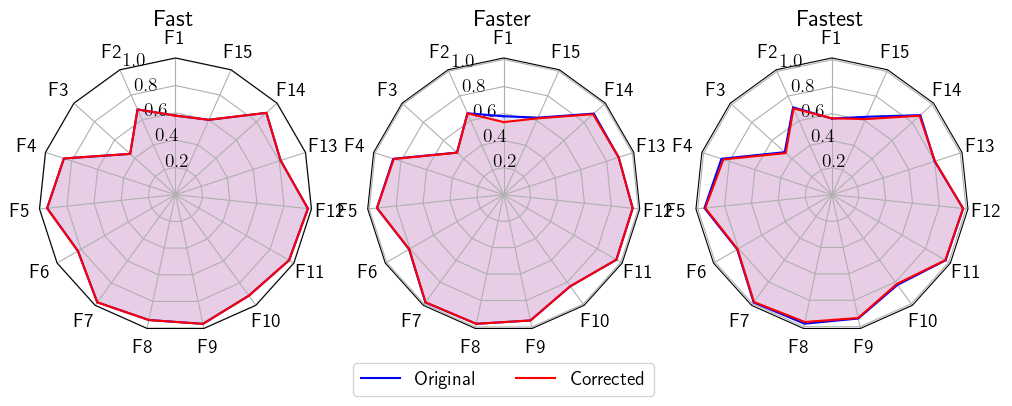

In [85]:
backends = ['Fast', 'Faster', 'Fastest']

def get_values(data, backend_name, feature_name, stat='mean'):
    g = data[data['backend'] == backend_name].groupby(['problem'])

    match stat:
        case 'median':
            return [v[feature_name].median() for _, v in g]

        case 'mean':
            return [v[feature_name].mean() for _, v in g]

        case 'max':
            return [v[feature_name].max() for _, v in g]

        case 'min':
            return [v[feature_name].min() for _, v in g]


header = [f'F{i}' for i in range(1, 16)]
print(header)

runs_data = runs_without_nls
runs_data.r2_test_v = runs_data.r2_test_v.clip(0, 1)
runs_data.r2_test_b = runs_data.r2_test_b.clip(0, 1)

data = [
    ('Fast',
     [get_values(runs_data, 'Mad_Transcendental_Fast', 'r2_test_b', stat='mean'),
      get_values(runs_data, 'Mad_Transcendental_Fast', 'r2_test_v', stat='mean')]),
    ('Faster',
     [get_values(runs_data, 'Mad_Transcendental_Faster', 'r2_test_b', stat='mean'),
      get_values(runs_data, 'Mad_Transcendental_Faster', 'r2_test_v', stat='mean')]),
    ('Fastest',
     [get_values(runs_data, 'Mad_Transcendental_Fastest', 'r2_test_b', stat='mean'),
      get_values(runs_data, 'Mad_Transcendental_Fastest', 'r2_test_v', stat='mean')]
    )
]

spoke_labels = header
colors = ['b', 'r', 'g', 'm', 'y']
labels = ('Original', 'Corrected')


theta = radar_factory.radar_factory(len(header), frame='polygon')

fig, axs = plt.subplots(figsize=(12, 6), nrows=1, ncols=3,
                        subplot_kw=dict(projection='radar'))
for ax, (title, case_data) in zip(axs.flat, data):

    ax.set_title(title, weight='bold', size='large', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.1, label='_nolegend_')
    ax.set_varlabels(spoke_labels)
    # ax.set_rgrids([0.2, 0.4, 0.6, 0.8])

legend = axs[0].legend(labels, labelspacing=0.1, fontsize=14, loc='upper center', bbox_to_anchor=(1.7, -0.08), ncols=2)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.25)
# fig.tight_layout()
# plt.savefig('correction.pdf', bbox_inches='tight')

In [86]:
data = [
    ('Eigen',
     [get_values(runs_without_nls, 'Eigen', 'r2_test_v', stat='median'),
      get_values(runs_with_nls, 'Eigen', 'r2_test_v', stat='median')]),
    ('Stl',
     [get_values(runs_without_nls, 'Stl', 'r2_test_v', stat='median'),
      get_values(runs_with_nls, 'Stl', 'r2_test_v', stat='median')]),
    ('Vdt',
    [get_values(runs_without_nls, 'Vdt', 'r2_test_v', stat='median'),
      get_values(runs_with_nls, 'Vdt', 'r2_test_v', stat='median')]),
    ('Mad-16',
     [get_values(runs_without_nls, 'Mad_Transcendental_Fast', 'r2_test_v', stat='median'),
      get_values(runs_with_nls, 'Mad_Transcendental_Fast', 'r2_test_v', stat='median')]),
    ('Mad-10',
     [get_values(runs_without_nls, 'Mad_Transcendental_Faster', 'r2_test_v', stat='median'),
      get_values(runs_with_nls, 'Mad_Transcendental_Faster', 'r2_test_v', stat='median')]),
    ('Mad-04',
     [get_values(runs_without_nls, 'Mad_Transcendental_Fastest', 'r2_test_v', stat='median'),
      get_values(runs_with_nls, 'Mad_Transcendental_Fastest', 'r2_test_v', stat='median')]
    )
]
data

[('Eigen',
  [[0.604055138990477,
    0.6978559676775407,
    0.4813865593526865,
    0.8612911320165797,
    0.959938341264831,
    0.8775888712719976,
    0.9970125895557008,
    0.9905744224161953,
    0.9961370929589752,
    0.9870846813127991,
    0.9908728740478163,
    0.9996562500486617,
    0.9999902171864019,
    0.897280724973676,
    0.7899572044915362],
   [0.5811912219303106,
    0.811896665675653,
    0.44627667397070503,
    0.8650582917812253,
    0.9601239195770437,
    0.8743203747179229,
    0.9934410223487122,
    0.9974547491462118,
    0.998945186619604,
    0.9991461645177312,
    0.9277534115329531,
    0.9999999456988572,
    0.9999999996735671,
    0.9999999953047947,
    0.8479664319108514]]),
 ('Stl',
  [[0.6179560104480541,
    0.7083436533914131,
    0.4834511911110748,
    0.8607364798866598,
    0.960032580448511,
    0.889327604713691,
    0.9968627628835205,
    0.988872236004642,
    0.9968526587120901,
    0.9879132167808482,
    0.9906495637378867,

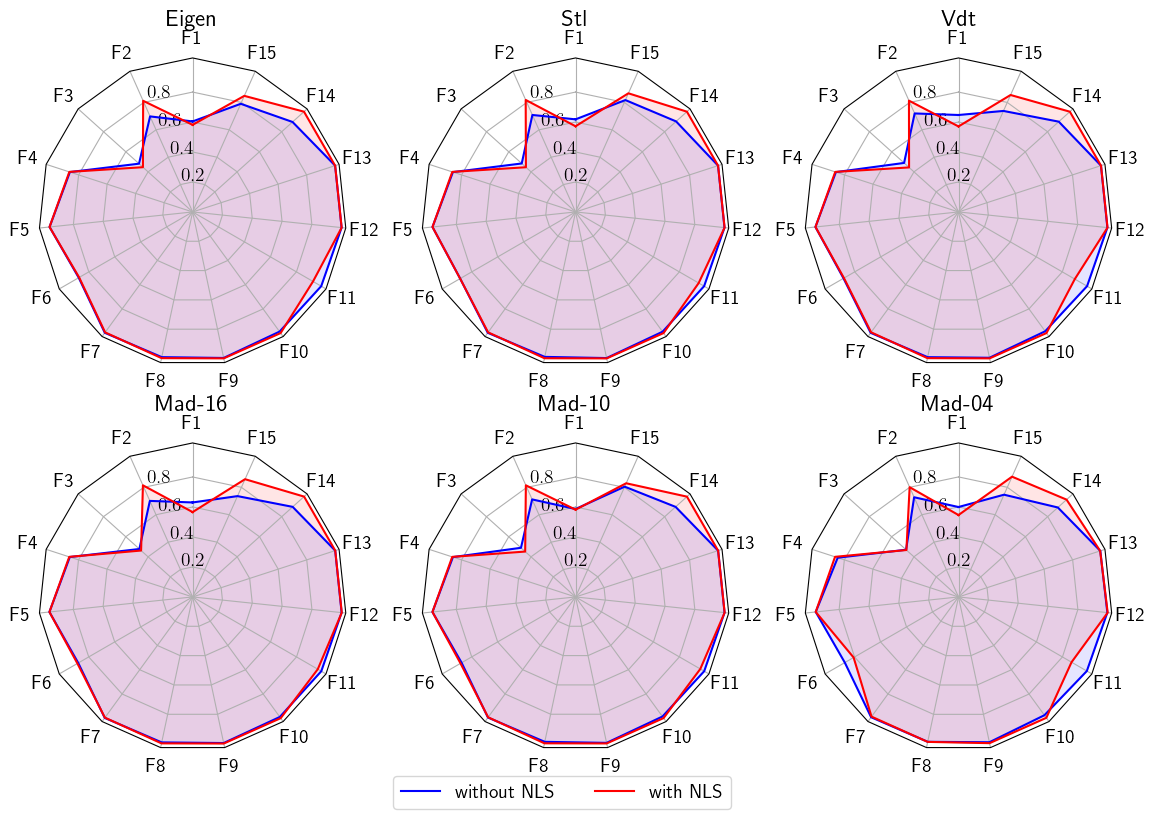

In [87]:

spoke_labels = header
colors = ['b', 'r', 'g', 'm', 'y']
labels = ('without NLS', 'with NLS')


theta = radar_factory.radar_factory(len(header), frame='polygon')

fig, axs = plt.subplots(figsize=(14, 9), nrows=2, ncols=3,
                        subplot_kw=dict(projection='radar'))
for ax, (title, case_data) in zip(axs.flat, data):

    ax.set_title(title, weight='bold', size='large', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.1, label='_nolegend_')
    ax.set_varlabels(spoke_labels)
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])

legend = axs[0, 0].legend(labels, labelspacing=0.1, fontsize=14, loc='upper center', bbox_to_anchor=(1.7, -1.3), ncols=2)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.25)
# plt.savefig('r2_test.pdf', bbox_inches='tight')

### Median difference of MAD-* vs Eigen

In [88]:
runs = runs_with_nls
eigen = runs[runs.backend == 'Eigen']
problems = runs.problem.unique()
backends = ['Mad_Transcendental_Fast', 'Mad_Transcendental_Faster', 'Mad_Transcendental_Fastest']

for i, p in enumerate(problems):
    m1 = eigen[eigen.problem == p]['r2_test_v'].clip(0,1).median()

    for j, b in enumerate(backends):
        m2 = runs[(runs.backend == b) & (runs.problem == p)]['r2_test_v'].clip(0,1).median()

        # print(b, end=' & ')
        print(f'{100*(m2-m1)/m1:.2f}', end=' & ')
        # print(f'{(m2-m1):.4f}', end=' & ')
    print()


-2.64 & 0.17 & -6.07 & 
0.35 & 0.40 & -1.38 & 
3.62 & 1.37 & 4.72 & 
-0.00 & -0.00 & 0.02 & 
-0.01 & -0.01 & -0.33 & 
0.14 & -0.11 & -0.73 & 
1.47 & 1.37 & -7.66 & 
0.08 & 0.09 & -0.98 & 
0.03 & 0.02 & -0.26 & 
-0.00 & -0.02 & -0.33 & 
3.88 & 3.58 & -6.23 & 
0.00 & -0.00 & -0.02 & 
0.00 & 0.00 & -0.72 & 
-0.00 & 0.00 & -3.07 & 
1.35 & -2.11 & 3.48 & 


### Statistical tests

In [89]:
runs = runs_with_nls
problems = runs.problem.unique()
print(problems)
backends = runs.backend.unique()
print(backends)
eigen = runs[runs.backend == 'Eigen']

names = {
   'Mad_Transcendental_Fast': 'Mad-16',
   'Mad_Transcendental_Faster': 'Mad-10',
   'Mad_Transcendental_Fastest': 'Mad-04',
   'Eigen':'Eigen',
   'Vdt':'Vdt',
   'Stl': 'Stl'
}

sig = np.full(shape=(len(problems), len(backends)-1), fill_value=np.nan)

for i, p in enumerate(problems):
    a = eigen[eigen.problem == p]['r2_test_v'].round(3)

    for j, b in enumerate([b for b in backends if b != 'Eigen']):
        b = runs[(runs.backend == b) & (runs.problem == p)]['r2_test_v'].round(3)

        sig[i, j] = mannwhitneyu(a, b, nan_policy='omit', alternative='greater')[1]

sig

stats = pd.DataFrame(data=sig, index=[f'$F_{{{i}}}$' for i in range(1, len(problems)+1)], columns=[b for b in backends if b != 'Eigen'])
stats.columns = [names[b] for b in backends if b != 'Eigen']
stats = stats[['Mad-16', 'Mad-10', 'Mad-04']]
stats

['Airfoil Self-Noise' 'Chemical-I' 'Concrete Compressive Strength'
 'Friedman-I' 'Friedman-II' 'Spatial Coevolution' 'Poly-10'
 'Vladislavleva-1' 'Vladislavleva-2' 'Vladislavleva-3' 'Vladislavleva-4'
 'Vladislavleva-5' 'Vladislavleva-6' 'Vladislavleva-7' 'Vladislavleva-8']
['Mad_Transcendental_Faster' 'Mad_Transcendental_Fast' 'Eigen' 'Vdt'
 'Mad_Transcendental_Fastest' 'Stl']


,Mad-16,Mad-10,Mad-04
$F_{1}$,0.078749,0.460100,1.447867e-03
$F_{2}$,0.631560,0.683567,3.120956e-01
$F_{3}$,0.643924,0.566944,9.650890e-01
$F_{4}$,0.215105,0.071536,9.548303e-01
$F_{5}$,0.270291,0.391317,5.400524e-19
$F_{6}$,0.807252,0.379115,2.927777e-05
$F_{7}$,0.818046,0.833022,2.592876e-02
$F_{8}$,0.776352,0.737828,8.466120e-10
$F_{9}$,0.734473,0.608193,9.116025e-17
$F_{10}$,0.474819,0.733590,2.262374e-13


In [90]:
table = stats.to_latex(index=False, float_format='{:.1e}'.format)
print(table)

\begin{tabular}{rrr}
\toprule
Mad-16 & Mad-10 & Mad-04 \\
\midrule
7.9e-02 & 4.6e-01 & 1.4e-03 \\
6.3e-01 & 6.8e-01 & 3.1e-01 \\
6.4e-01 & 5.7e-01 & 9.7e-01 \\
2.2e-01 & 7.2e-02 & 9.5e-01 \\
2.7e-01 & 3.9e-01 & 5.4e-19 \\
8.1e-01 & 3.8e-01 & 2.9e-05 \\
8.2e-01 & 8.3e-01 & 2.6e-02 \\
7.8e-01 & 7.4e-01 & 8.5e-10 \\
7.3e-01 & 6.1e-01 & 9.1e-17 \\
4.7e-01 & 7.3e-01 & 2.3e-13 \\
9.4e-01 & 9.5e-01 & 2.0e-02 \\
1.0e+00 & 4.1e-02 & 1.2e-13 \\
9.9e-01 & 9.4e-01 & 1.8e-30 \\
4.7e-01 & 4.5e-01 & 1.2e-06 \\
5.6e-01 & 1.6e-01 & 8.2e-01 \\
\bottomrule
\end{tabular}



In [91]:
styler = stats.style\
  .background_gradient(axis=None, cmap="gray", vmin=-0.05, vmax=0.1)\
  .highlight_null(props="background-color:white; color:white;")\
  .format('{:.1e}')\
  .format_index(escape="latex", axis=1)

styler

,Mad-16,Mad-10,Mad-04
$F_{1}$,7.9e-02,4.6e-01,1.4e-03
$F_{2}$,6.3e-01,6.8e-01,3.1e-01
$F_{3}$,6.4e-01,5.7e-01,9.7e-01
$F_{4}$,2.2e-01,7.2e-02,9.5e-01
$F_{5}$,2.7e-01,3.9e-01,5.4e-19
$F_{6}$,8.1e-01,3.8e-01,2.9e-05
$F_{7}$,8.2e-01,8.3e-01,2.6e-02
$F_{8}$,7.8e-01,7.4e-01,8.5e-10
$F_{9}$,7.3e-01,6.1e-01,9.1e-17
$F_{10}$,4.7e-01,7.3e-01,2.3e-13


In [92]:
table = styler.to_latex(convert_css=True)
print(table)

\begin{tabular}{lrrr}
 & Mad-16 & Mad-10 & Mad-04 \\
$F_{1}$ & {\cellcolor[HTML]{DBDBDB}} \color[HTML]{000000} 7.9e-02 & {\cellcolor[HTML]{FFFFFF}} \color[HTML]{000000} 4.6e-01 & {\cellcolor[HTML]{575757}} \color[HTML]{F1F1F1} 1.4e-03 \\
$F_{2}$ & {\cellcolor[HTML]{FFFFFF}} \color[HTML]{000000} 6.3e-01 & {\cellcolor[HTML]{FFFFFF}} \color[HTML]{000000} 6.8e-01 & {\cellcolor[HTML]{FFFFFF}} \color[HTML]{000000} 3.1e-01 \\
$F_{3}$ & {\cellcolor[HTML]{FFFFFF}} \color[HTML]{000000} 6.4e-01 & {\cellcolor[HTML]{FFFFFF}} \color[HTML]{000000} 5.7e-01 & {\cellcolor[HTML]{FFFFFF}} \color[HTML]{000000} 9.7e-01 \\
$F_{4}$ & {\cellcolor[HTML]{FFFFFF}} \color[HTML]{000000} 2.2e-01 & {\cellcolor[HTML]{CFCFCF}} \color[HTML]{000000} 7.2e-02 & {\cellcolor[HTML]{FFFFFF}} \color[HTML]{000000} 9.5e-01 \\
$F_{5}$ & {\cellcolor[HTML]{FFFFFF}} \color[HTML]{000000} 2.7e-01 & {\cellcolor[HTML]{FFFFFF}} \color[HTML]{000000} 3.9e-01 & {\cellcolor[HTML]{555555}} \color[HTML]{F1F1F1} 5.4e-19 \\
$F_{6}$ & {\cellcolor[